# Import Libraries

In [5]:
# data analysis and wrangling
import pandas as pd 
import numpy as np 

# visualization
import seaborn as sns
import matplotlib.pyplot as plt 
from pandas_profiling import ProfileReport

# encoders
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.base import clone 

#metrics
from sklearn.model_selection import cross_val_score #k fold cv
from sklearn.metrics import roc_curve, accuracy_score, plot_confusion_matrix, classification_report, roc_auc_score, plot_roc_curve, precision_score, recall_score

# model creation
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

#feature importance
from xgboost import XGBClassifier
from pdpbox.pdp import pdp_interact, pdp_interact_plot
# import shap



# Data Wrangling and Exploration

In [6]:
#Create function to import data
def wrangle(path):
    df = pd.read_csv(path)

    #drop null colomns
    df.drop('Unnamed: 0', axis = 1, inplace = True) 

    #drop high null count features
    df.drop(columns = ['Rotten Tomatoes', 'Age'], inplace = True)

    #drop columns that don't fit with finding what features affect if a show goes on Netflix
    df.drop(columns = ['Hulu', 'Prime Video', 'Disney+'], inplace = True)

    #drop high cardinality features
    high_card_cols = ['Title', 'Directors', 'ID', 'Type']
    df.drop(columns = high_card_cols, inplace = True)

    #drop_cols = []
    return df

In [7]:
df = wrangle('MoviesOnStreamingPlatforms_updated.csv')

pd.set_option('display.max_columns', 100)

In [8]:
df.isnull().sum().max()

599

In [9]:
# df.select_dtypes(include='object').describe()

In [10]:
# df.select_dtypes('object').nunique()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16744 entries, 0 to 16743
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      16744 non-null  int64  
 1   IMDb      16173 non-null  float64
 2   Netflix   16744 non-null  int64  
 3   Genres    16469 non-null  object 
 4   Country   16309 non-null  object 
 5   Language  16145 non-null  object 
 6   Runtime   16152 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 915.8+ KB


In [12]:
df.head()

,Year,IMDb,Netflix,Genres,Country,Language,Runtime
0,2010,8.8,1,"Action,Adventure,Sci-Fi,Thriller","United States,United Kingdom","English,Japanese,French",148.0
1,1999,8.7,1,"Action,Sci-Fi",United States,English,136.0
2,2018,8.5,1,"Action,Adventure,Sci-Fi",United States,English,149.0
3,1985,8.5,1,"Adventure,Comedy,Sci-Fi",United States,English,116.0
4,1966,8.8,1,Western,"Italy,Spain,West Germany",Italian,161.0


In [13]:
df['Netflix'].value_counts()

0    13184
1     3560
Name: Netflix, dtype: int64

# Categorical Observation Clean-up

- Features 'Language', 'Genre', 'Country' have some observations with multiple values (e.g. Country could contain observation of 'Mexico,South Korea,Colombia')
- Goal is to convert observation to binary values of each country (e.g. 'Mexico,South Korea,Colombia' would add 1 to a Mexico feature, South Korea feature, Columbia feature)

### Language Expanding

In [14]:
def col_lang(df, df2, df_orig):
    #use get_dummies to convert values into column names
    df_dum = pd.get_dummies(df)

    #drop any columns that contain a comma since that contains mult languages
    for col in df_dum.columns:
        if ',' in col:
            df_dum.drop(columns = col, inplace = True)

    #remove Language_ copy from column name
    df_dum.columns = df_dum.columns.str.replace('Language_', '')
    
    #concat the Language feature from the original df to this df
    df_final = pd.concat([df2, df_dum], axis=1)
    
    # fill 'Language' col with na values with string copy so it can be iterable
    df_final['Language'] = df_final['Language'].fillna('None Provided')

    # iterate over column names to fill values with 1 and 0 based on 'Language'
    for col in df_final.columns[1:]:
        for i, value in enumerate(df_final['Language'].values):
            if col in value:
                df_final[col].values[i] = 1
            else: 
                df_final[col].values[i] = 0

    # drop duplicate values in df_lang so merge doesn't become huge
    df_final.drop_duplicates(inplace = True)

    # merge df_final with original  
    df_orig = df_orig.merge(df_final, how = 'left', on = 'Language')
    df_orig.drop(columns = 'Language', inplace = True)

    return df_orig

### Country Expanding

In [15]:
def col_country(df, df2, df_orig):
    #use get_dummies to convert values into column names
    df_dum = pd.get_dummies(df)

    #drop any columns that contain a comma since that contains mult coutries
    for col in df_dum.columns:
        if ',' in col:
            df_dum.drop(columns = col, inplace = True)

    #remove Country_ copy from column name
    df_dum.columns = df_dum.columns.str.replace('Country_', '')
    
    #concat the Country feature from the original df to this df
    df_final = pd.concat([df2, df_dum], axis=1)
    
    # fill 'Country' col with na values with string copy so it can be iterable
    df_final['Country'] = df_final['Country'].fillna('None Provided')

    # iterate over column names to fill values with 1 and 0 based on 'Country'
    for col in df_final.columns[1:]:
        for i, value in enumerate(df_final['Country'].values):
            if col in value:
                df_final[col].values[i] = 1
            else: 
                df_final[col].values[i] = 0

    # drop duplicate values in df_final so merge doesn't become huge
    df_final.drop_duplicates(inplace = True)

    # merge df_final with original  
    df_orig = df_orig.merge(df_final, how = 'left', on = 'Country')
    df_orig.drop(columns = 'Country', inplace = True)

    return df_orig

### Genres Expanding

In [16]:
def col_genres(df, df2, df_orig):
    #use get_dummies to convert values into column names
    df_dum = pd.get_dummies(df)

    #drop any columns that contain a comma since that contains mult genres
    for col in df_dum.columns:
        if ',' in col:
            df_dum.drop(columns = col, inplace = True)

    #remove Genres_ copy from column name
    df_dum.columns = df_dum.columns.str.replace('Genres_', '')
    
    #concat the Genres feature from the original df to this df
    df_final = pd.concat([df2, df_dum], axis=1)
    
    # fill 'Genres' col with na values with string copy so it can be iterable
    df_final['Genres'] = df_final['Genres'].fillna('None Provided')

    # iterate over column names to fill values with 1 and 0 based on 'Genres'
    for col in df_final.columns[1:]:
        for i, value in enumerate(df_final['Genres'].values):
            if col in value:
                df_final[col].values[i] = 1
            else: 
                df_final[col].values[i] = 0

    # drop duplicate values in df_final so merge doesn't become huge
    df_final.drop_duplicates(inplace = True)

    # merge df_final with original  
    df_orig = df_orig.merge(df_final, how = 'left', on = 'Genres')
    df_orig.drop(columns = 'Genres', inplace = True)

    return df_orig

In [17]:
#Expand language, country, and genres column in original dataframe for modeling
df = col_lang(df[['Language']], df[['Language']], df)
df = col_country(df[['Country']], df[['Country']], df)
df = col_genres(df[['Genres']], df[['Genres']], df)

In [18]:
df.head()

,Year,IMDb,Netflix,Runtime,Afrikaans,Akan,Albanian,Arabic,Assamese,Azerbaijani,Basque,Bengali,Bhojpuri,Bosnian,Brazilian Sign Language,Bulgarian,Cantonese,Catalan,Chinese,Croatian,Czech,Danish,Dari,Dutch,English,Estonian,Filipino,Finnish,French,Georgian,German,Greek,Gujarati,Hebrew,Hindi,Hungarian,Icelandic,Indonesian,Italian,Japanese,Kannada,Kinyarwanda,Kirghiz,Korean,Latin,Latvian,Macedonian,Malay,Malayalam,Mandarin,...,Russia,Saudi Arabia,Serbia,Singapore,South Africa,South Korea,Soviet Union,Spain,Sri Lanka,Sweden,Switzerland,Taiwan,Thailand,Trinidad and Tobago,Turkey,U.S. Virgin Islands,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Venezuela,West Germany,Yugoslavia,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,2010,8.8,1,148.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1999,8.7,1,136.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018,8.5,1,149.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1985,8.5,1,116.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1966,8.8,1,161.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
print(df.shape)
print(df.columns[0])

(16744, 201)
Year


In [20]:
# Comment to remember code
# 'English' in df_lang['Language'].values[0]
    

In [21]:
# Comment to remember how code works for iterable

# for i, value in enumerate(df_lang['Language'].values):
#     print(i)
#     print(value)
#     print(type(value))

# Target creation and Splitting Data

Look into what factors could determine if a show gets on to Netflix

In [22]:
#Create target variable, set without target, and set with only target
target = 'Netflix'
X = df.drop(columns = target)
y = df[target]

In [23]:
assert len(X) == len(y)

### Split into train, test, val data

Will split randomly. Won't split by year since I would rather have that as a feature

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

In [25]:
assert len(X_train + X_test + X_val == len(X))
assert len(y_train + y_test + y_val == len(y))

# Create Model

### Model based on results of randomized search and grid search

In [26]:
model = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(strategy = 'mean'),
                         StandardScaler(),
                         RandomForestClassifier(random_state=42,
                                                max_depth = 8,
                                                n_estimators = 55)
                      )
                                       
                      

model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=8, n_estimators=55,
                                        random_state=42))])

### Used for creating randomized search and Grid Search models

In [27]:
# # Model for Randomized Search and Grid Search
# model_rf = make_pipeline(OrdinalEncoder(),
#                          SimpleImputer(),
#                          RandomForestClassifier(random_state=42))

# # param grid for Randomized Search and Grid Search
# param_grid = {
#     'simpleimputer__strategy': ['mean', 'median'],
#     'randomforestclassifier__max_depth': range(5, 15, 1),
#     'randomforestclassifier__n_estimators': range(0, 110, 10)
# }

In [76]:
# dir(model_xgb.named_steps['xgbclassifier'])

['_Booster',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_n_features',
 '_estimator_type',
 '_features_count',
 '_get_param_names',
 '_get_tags',
 '_le',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_set_evaluation_result',
 '_validate_data',
 '_wrap_evaluation_matrices',
 'apply',
 'base_score',
 'booster',
 'classes_',
 'coef_',
 'colsample_bylevel',
 'colsample_bynode',
 'colsample_bytree',
 'evals_result',
 'feature_importances_',
 'fit',
 'gamma',
 'get_booster',
 'get_num_boosting_rounds',
 'get_params',
 'get_xgb_params',
 'gpu_id',
 'importance_type',
 'interaction_constraints',
 'inter

### Randomized Search

In [29]:
# model_rs = RandomizedSearchCV(
#     model_rf,
#     param_distributions=param_grid,
#     n_iter=20,
#     cv=None,
#     n_jobs=-1,
#     verbose = 1
# )

# model_rs.fit(X_train, y_train)

In [30]:
# model_rs.best_params_

In [ ]:
# model_rs.best_score_

### Grid Search


In [32]:
# model_gs = GridSearchCV(
#     model_rf,
#     param_grid = param_grid,
#     n_jobs = -1,
#     cv = None,
#     verbose = 1
# )

# # model_gs.fit(X_train, y_train)

In [33]:
# model_gs.best_params_

In [34]:
# model_gs.best_score_

# XGBoost

In [ ]:
model_xgb = make_pipeline(OrdinalEncoder(),
                          SimpleImputer(strategy = 'median'),
                          XGBClassifier(random_state = 42,
                                        n_estimators=60,
                                        max_depth = 5,
                                        learning_rate= 0.0002368421052631579,
                                        n_jobs=-1))

model_xgb.fit(X_train, y_train)

In [ ]:
# dir(model_xgb.named_steps['xgbclassifier'])


In [ ]:
# np.linspace(0,0.001, 10)

In [ ]:
# # Model for Randomized Search on XGBoost
# model_xgb_rs = make_pipeline(OrdinalEncoder(),
#                              SimpleImputer(),
#                              XGBClassifier())

# # param grid for Randomized Search and Grid Search
# param_grid_xgb = {
#     'simpleimputer__strategy': ['mean', 'median'],
#     'xgbclassifier__max_depth': range(0, 10, 1),
#     'xgbclassifier__n_estimators': range(0, 100, 10),
#     'xgbclassifier__learning_rate': np.linspace(0,0.0005, 20) # range should originally be between [0.0001, 0.001, 0.01, 0.1]
# }

In [ ]:
# model_XGB_rs = RandomizedSearchCV(
#     model_xgb_rs,
#     param_distributions=param_grid_xgb,
#     n_iter=20,
#     cv=None,
#     n_jobs=-1,
#     verbose = 1
# )

# model_XGB_rs.fit(X_train, y_train)

In [ ]:
# model_XGB_rs.best_params_

In [ ]:
# print('XG Boost 60, d = 5. r = 0.0002368421052631579 Validation Accuracy Train: ',model_xgb.score(X_train, y_train))
# print('XG Boost 60, d = 5. r = 0.0002368421052631579 Validation Accuracy Val: ',model_xgb.score(X_val, y_val))
# print('XG Boost 60, d = 5. r = 0.0002368421052631579 Validation Accuracy Test: ',model_xgb.score(X_test, y_test))


In [ ]:
# XG Boost 60, d = 5. r = 0.0002368421052631579 Accuracy Train:  0.8191319928329683
# XG Boost 60, d = 5. r = 0.0002368421052631579 Accuracy Val:  0.8044192296207823
# XG Boost 60, d = 5. r = 0.0002368421052631579 Accuracy Test:  0.8139743206927441

# Check Metrics

### Establish Baseline

In [35]:
#Baseline aaccuarcy
acc_train = y_train.value_counts(normalize = True).max()
print('baseline accuracy', acc_train)

baseline accuracy 0.7879753135576348


### Check accuracy scores for train and val set

In [62]:
acc_train = model.score(X_train, y_train)
acc_val = model.score(X_val, y_val)
acc_test = model.score(X_test, y_test)

print('XGB Accuracy Train: ',model_xgb.score(X_train, y_train)) #XG Boost 60, d = 5. r = 0.0002368421052631579 
print('XGB Accuracy Val: ',model_xgb.score(X_val, y_val))       #XG Boost 60, d = 5. r = 0.0002368421052631579 
print('XGB Accuracy Test: ',model_xgb.score(X_test, y_test))    #XG Boost 60, d = 5. r = 0.0002368421052631579 
print()
print('RF Training Accuracy:', acc_train)
print('RF Validation Accuracy:', acc_val)
print('RF Testing Accuracy:', acc_test)


XGB Accuracy Train:  0.8191319928329683
XGB Accuracy Val:  0.8044192296207823
XGB Accuracy Test:  0.8139743206927441

RF Training Accuracy: 0.8122635874975115
RF Validation Accuracy: 0.806509405792774
RF Testing Accuracy: 0.80501642281278


In [37]:
# acc_train_rs = model_rs.score(X_train, y_train)
# acc_val_rs = model_rs.score(X_val, y_val)
# acc_test_rs = model_rs.score(X_test, y_test)

# print('Training e = 100 d = 14 RS Accuracy:', acc_train_rs)
# print('Validation e = 100 d = 14 RS Accuracy:', acc_val_rs)
# print('Testing e = 100 d = 14 RS Accuracy:', acc_test_rs)

In [38]:
# Training e = 100 d = 14 RS Accuracy: 0.8593470037826001
# Validation e = 100 d = 14 RS Accuracy: 0.8211406389967154
# Testing e = 100 d = 14 RS Accuracy: 0.817258883248731

### Check ROC AUC Curve Metrics

In [39]:
# Create ROC curve to find fpr, tpr and threshold for model
fpr, tpr, threshold = roc_curve(y_val, model.predict_proba(X_val)[:,-1])

In [40]:
# create df for fpr, tpr, threshold
pd.DataFrame({'Threshold': threshold, 'fpr': fpr, 'tpr': tpr})

,Threshold,fpr,tpr
0,1.712471,0.000000,0.000000
1,0.712471,0.000000,0.001361
2,0.596355,0.000000,0.023129
3,0.595753,0.000383,0.023129
4,0.575233,0.000383,0.035374
...,...,...,...
1112,0.071345,0.996174,1.000000
1113,0.071235,0.997322,1.000000
1114,0.068836,0.998087,1.000000
1115,0.067771,0.998852,1.000000


In [63]:
# Random Forest roc auc score for the test and val
roc_auc_score_val = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
roc_auc_score_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

# XGBoost roc auc score for the test and val
roc_auc_score_val_xgb = roc_auc_score(y_val, model_xgb.predict_proba(X_val)[:,1])
roc_auc_score_test_xgb = roc_auc_score(y_test, model_xgb.predict_proba(X_test)[:,1])

print("random forest model roc auc score for val is", roc_auc_score_val)
print("random forest model roc auc score for test is", roc_auc_score_test)
print()
print("XGboost model roc auc score for val is", roc_auc_score_val_xgb)
print("XGBoost forest model roc auc score for test is", roc_auc_score_test_xgb)

random forest model roc auc score for val is 0.830667155921282
random forest model roc auc score for test is 0.8261348419380546

random forest model roc auc score for val is 0.8046937214059304
random forest model roc auc score for test is 0.8075959729578808


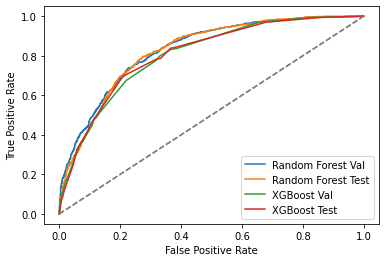

In [65]:
# ROC Curve for Val and test
rf_val = plot_roc_curve(model, X_val, y_val, label='Random Forest Val')
rf_test = plot_roc_curve(model, X_test, y_test, ax = rf_val.ax_, label='Random Forest Test')
xgb_val = plot_roc_curve(model_xgb, X_val, y_val, ax = rf_val.ax_, label='XGBoost Val')
xgb_test = plot_roc_curve(model_xgb, X_test, y_test, ax = rf_val.ax_, label='XGBoost Test')

plt.plot([(0,0), (1,1)], color='grey', linestyle='--')
plt.legend();

### Confusion Matrix

In [43]:
# RF Model Classification report to see precision and recall values using test data
print(classification_report(y_test, 
                            model.predict(X_test),
                            target_names = ['Not On Netflix', 'On Netflix']))

                precision    recall  f1-score   support

Not On Netflix       0.81      0.99      0.89      2654
    On Netflix       0.77      0.09      0.16       695

      accuracy                           0.81      3349
     macro avg       0.79      0.54      0.52      3349
  weighted avg       0.80      0.81      0.74      3349



In [59]:
# XGBoost Classification report to see precision and recall values using test data
print(classification_report(y_test, 
                            model_xgb.predict(X_test),
                            target_names = ['Not On Netflix', 'On Netflix']))

                precision    recall  f1-score   support

Not On Netflix       0.84      0.94      0.89      2654
    On Netflix       0.60      0.32      0.42       695

      accuracy                           0.81      3349
     macro avg       0.72      0.63      0.65      3349
  weighted avg       0.79      0.81      0.79      3349



# Feature Importance

### Get Top 10 Features

In [44]:
# Random Forest Model feature importance
importances = model.named_steps['randomforestclassifier'].feature_importances_
features = model.named_steps['ordinalencoder'].get_feature_names()
#features = X_train.columns

feat_imp=pd.Series(importances, index=features).sort_values()

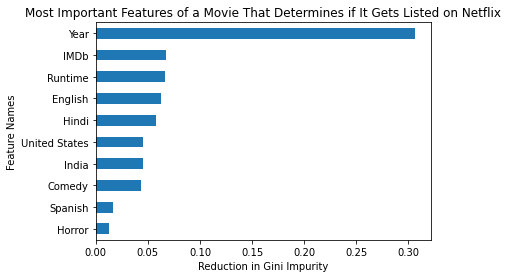

In [45]:
# Random Forest Model Tope 10 Features
feat_imp.tail(10).plot(kind = 'barh')
plt.xlabel('Reduction in Gini Impurity')
plt.ylabel('Feature Names')
plt.title('Most Important Features of a Movie That Determines if It Gets Listed on Netflix')
plt.show()

In [74]:
# XGBoost Model feature importance
importances_xgb = model_xgb.named_steps['xgbclassifier'].feature_importances_
# features = model.named_steps['ordinalencoder'].get_feature_names()
features_xgb = X_train.columns

feat_imp_xgb=pd.Series(importances_xgb, index=features_xgb).sort_values()

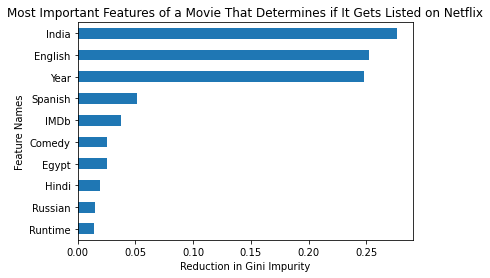

In [75]:
# XGBoost Model Top 10 Features
feat_imp_xgb.tail(10).plot(kind = 'barh')
plt.xlabel('Reduction in Gini Impurity')
plt.ylabel('Feature Names')
plt.title('Most Important Features of a Movie That Determines if It Gets Listed on Netflix')
plt.show()

# Partial Dependence Plots

In [56]:
# Later, when you save matplotlib images to include in blog posts or web apps,
# increase the dots per inch (double it), so the text isn't so fuzzy
plt.rcParams['figure.dpi'] = 72

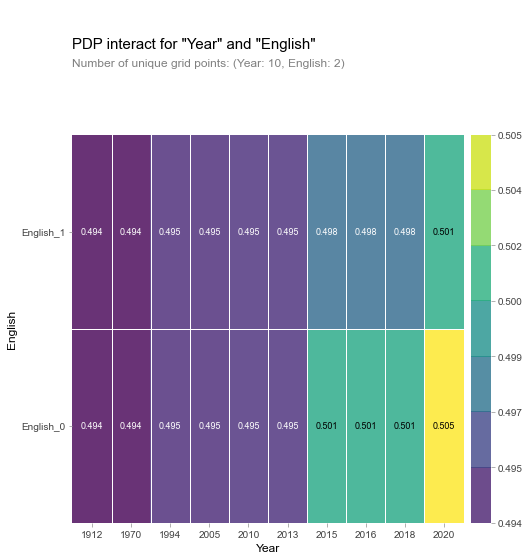

In [77]:
features = ['Year', 'English']

#Create PDP model based on random forest model
interact = pdp_interact(model=model_xgb,
           dataset=X_val.dropna(), 
           model_features=X_val.columns,
           features= features)

#Plot PDD interact model between Longitude and Latitude 
pdp_interact_plot(interact, feature_names=features, plot_type='grid');

# Shapley Value Plot

In [58]:
# from xgboost import XGBRegressor
# model_gb = make_pipeline(OrdinalEncoder(),
#                          XGBRegressor(n_estimators=200, 
#                                       objective='reg:squarederror', 
#                                       n_jobs=-1))
# model_gb.fit(X_train, y_train)
# y_pred = model_gb.predict(X_val)
# print('Gradient Boosting R^2', r2_score(y_val, y_pred))

NameError: name 'r2_score' is not defined

In [ ]:
# oe = OrdinalEncoder()
# X_train_T = oe.fit_transform(X_train)
# model_gb = XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
# model_gb.fit(X_train_T, y_train)

In [ ]:
# get one observation from X_test

# row = X_test.iloc[[1]]
# row = oe.transform(row)

In [ ]:
# explainer = shap.TreeExplainer(model_gb) # do not like pipeline
# shap_values = explainer.shap_values(row)
# shap_values 

In [ ]:
# y_train.mean(), model_gb.predict(X_train_T).mean()

In [ ]:
# shap.initjs()
# shap.force_plot(
#                 base_value=explainer.expected_value,
#                 shap_values=shap_values,
#                 features=row)